In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import skew, kurtosis, ttest_rel, wilcoxon
import seaborn as sns  
from glob import glob

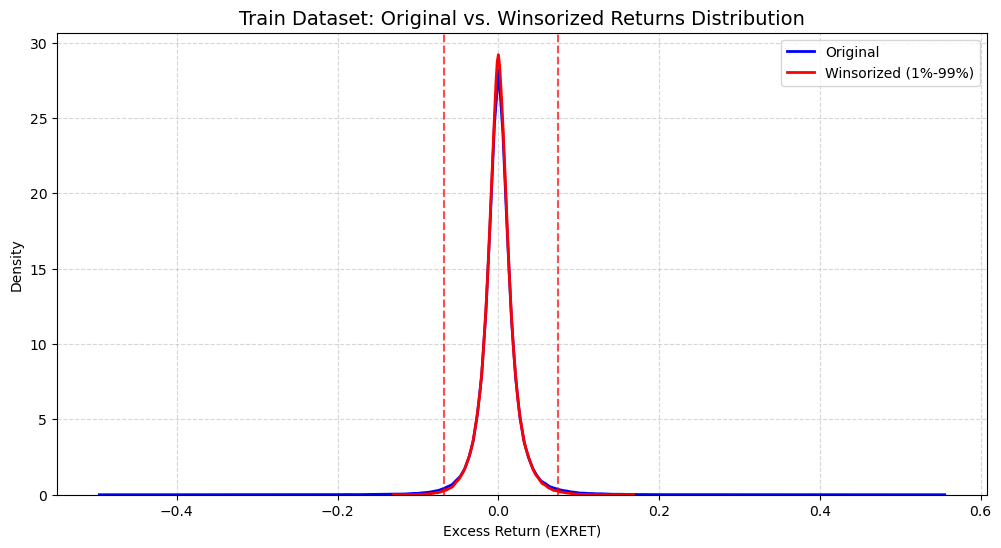

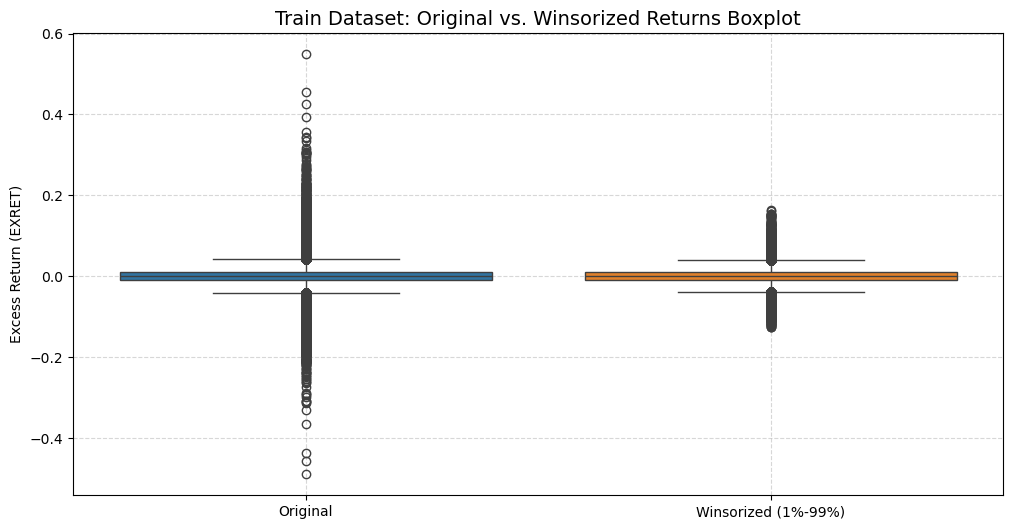

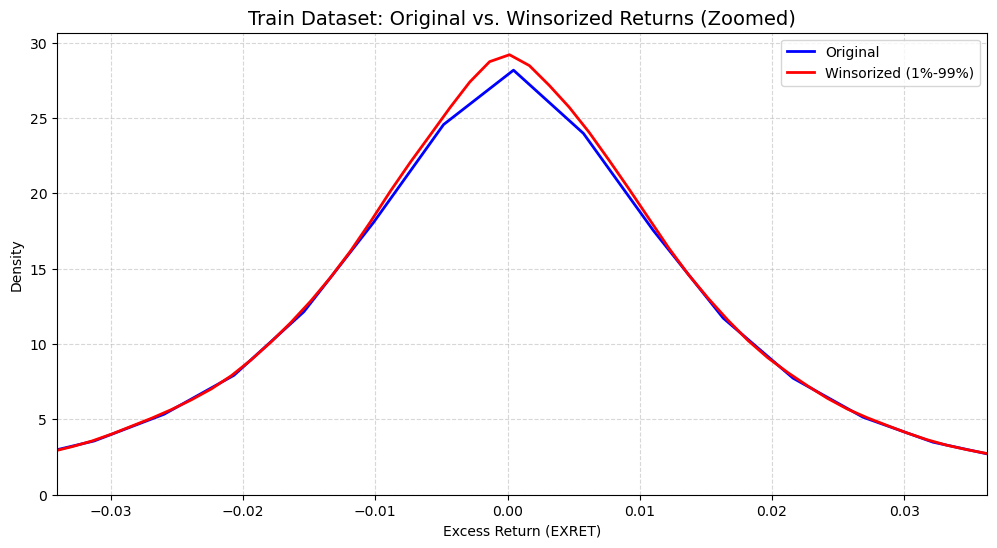


=== Train Dataset Statistics Comparison ===
            Original     Winsorized
count  201232.000000  197133.000000
mean        0.000634       0.000548
std         0.024802       0.019875
min        -0.489854      -0.125371
1%         -0.067505      -0.052864
5%         -0.034062      -0.031190
25%        -0.009874      -0.009583
50%         0.000259       0.000259
75%         0.010623       0.010349
95%         0.036257       0.033095
99%         0.074809       0.057569
max         0.548893       0.163235

Clipped values:
- Below 1% quantile: 2012 (0.9998%)
- Above 99% quantile: 2013 (1.0003%)
- Total clipped: 4025 (2.0002%)


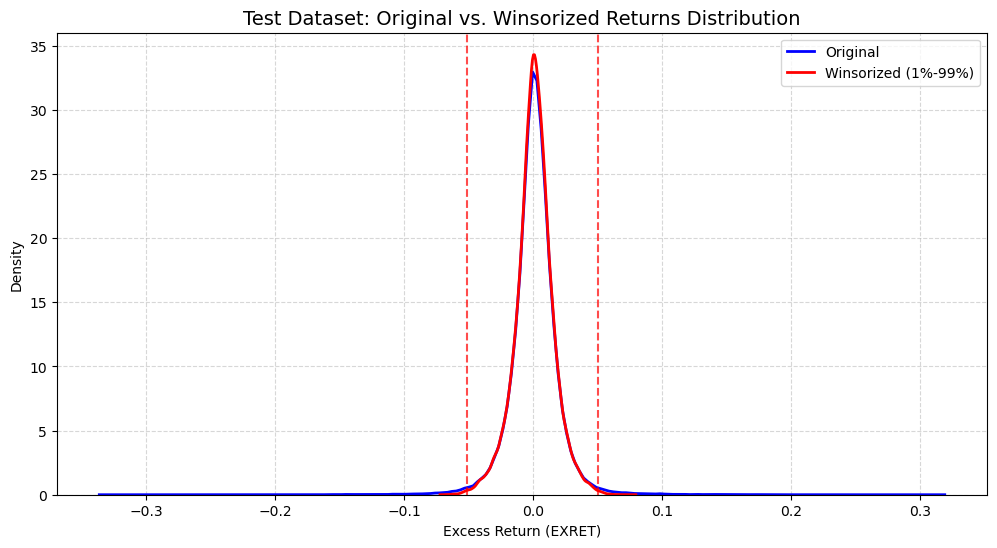

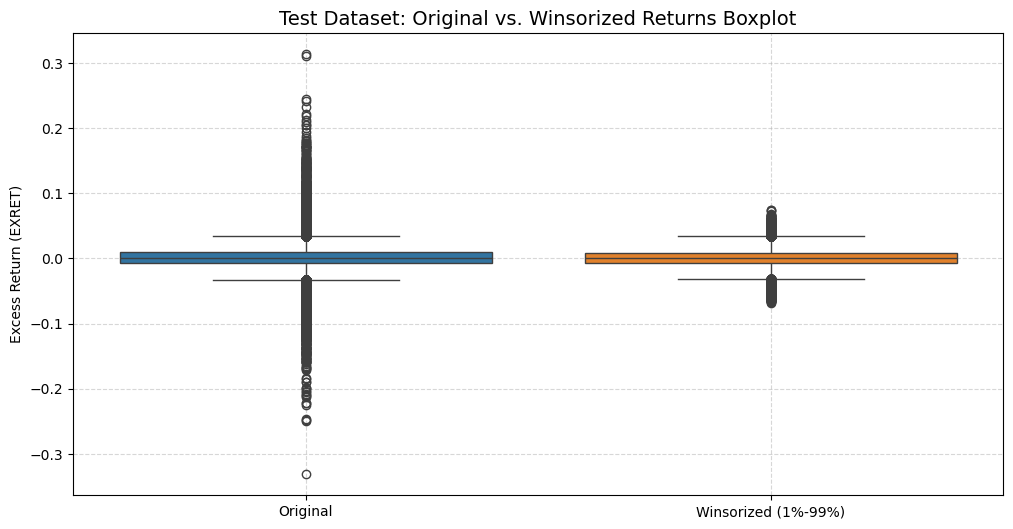

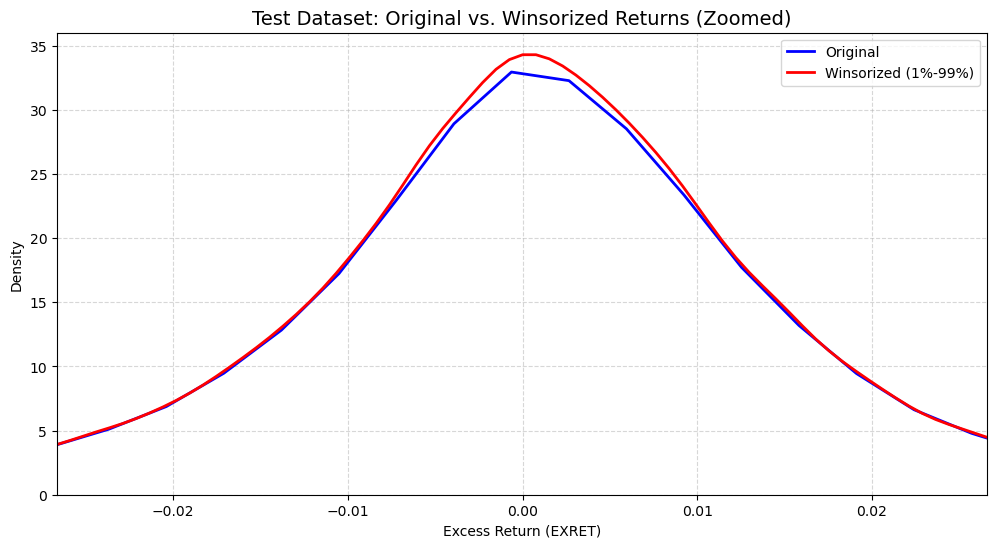


=== Test Dataset Statistics Comparison ===
            Original     Winsorized
count  113200.000000  110900.000000
mean        0.000660       0.000668
std         0.018732       0.014757
min        -0.331109      -0.068123
1%         -0.051395      -0.039831
5%         -0.026658      -0.024469
25%        -0.007584      -0.007354
50%         0.000852       0.000852
75%         0.009314       0.009097
95%         0.026599       0.024719
99%         0.050312       0.038795
max         0.313369       0.075003

Clipped values:
- Below 1% quantile: 1132 (1.0000%)
- Above 99% quantile: 1131 (0.9991%)
- Total clipped: 2263 (1.9991%)
All comparison plots and statistics generated!


In [12]:


os.makedirs("figures_comparison", exist_ok=True)
train_original = pd.read_csv("CRSP_2000_2015_top50_with_exret.csv", parse_dates=["date"])
test_original = pd.read_csv("CRSP_2016_2024_top50_with_exret.csv", parse_dates=["date"])

train_winsorized = pd.read_csv("CRSP_2000_2015_top50_with_exret_cleaned.csv", parse_dates=["date"])
test_winsorized = pd.read_csv("CRSP_2016_2024_top50_with_exret_cleaned.csv", parse_dates=["date"])

def plot_kde_comparison(original_df, winsorized_df, dataset_name="Train", output_dir="figures_comparison"):
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(original_df["EXRET"], label="Original", color="blue", lw=2)
    sns.kdeplot(winsorized_df["EXRET"], label="Winsorized (1%-99%)", color="red", lw=2)
    
    plt.title(f"{dataset_name} Dataset: Original vs. Winsorized Returns Distribution", fontsize=14)
    plt.xlabel("Excess Return (EXRET)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    
    q_low = np.percentile(original_df["EXRET"], 1)
    q_high = np.percentile(original_df["EXRET"], 99)
    plt.axvline(x=q_low, color="red", linestyle="--", alpha=0.7, label="1% quantile")
    plt.axvline(x=q_high, color="red", linestyle="--", alpha=0.7, label="99% quantile")
    
    plt.savefig(os.path.join(output_dir, f"{dataset_name.lower()}_kde_comparison.png"), dpi=300)
    plt.show()
    plt.close()

def plot_boxplot_comparison(original_df, winsorized_df, dataset_name="Train", output_dir="figures_comparison"):
    plt.figure(figsize=(12, 6))
    
    comparison_df = pd.DataFrame({
        "Original": original_df["EXRET"],
        "Winsorized (1%-99%)": winsorized_df["EXRET"]
    })
    
    sns.boxplot(data=comparison_df)
    
    plt.title(f"{dataset_name} Dataset: Original vs. Winsorized Returns Boxplot", fontsize=14)
    plt.ylabel("Excess Return (EXRET)")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    plt.savefig(os.path.join(output_dir, f"{dataset_name.lower()}_boxplot_comparison.png"), dpi=300)
    plt.show()
    plt.close()

def plot_zoomed_kde_comparison(original_df, winsorized_df, dataset_name="Train", output_dir="figures_comparison"):
    plt.figure(figsize=(12, 6))
    
    q_low = np.percentile(original_df["EXRET"], 5)
    q_high = np.percentile(original_df["EXRET"], 95)
    
    sns.kdeplot(original_df["EXRET"], label="Original", color="blue", lw=2)
    
    sns.kdeplot(winsorized_df["EXRET"], label="Winsorized (1%-99%)", color="red", lw=2)
    
    plt.title(f"{dataset_name} Dataset: Original vs. Winsorized Returns (Zoomed)", fontsize=14)
    plt.xlabel("Excess Return (EXRET)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlim(q_low, q_high)
    
    plt.savefig(os.path.join(output_dir, f"{dataset_name.lower()}_kde_zoomed_comparison.png"), dpi=300)
    plt.show()
    plt.close()

def print_stats_comparison(original_df, winsorized_df, dataset_name="Train"):
    print(f"\n=== {dataset_name} Dataset Statistics Comparison ===")
    
    orig_stats = original_df["EXRET"].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    wins_stats = winsorized_df["EXRET"].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    
    comparison = pd.DataFrame({
        "Original": orig_stats,
        "Winsorized": wins_stats
    })
    
    print(comparison)
    
    n_clipped_low = (original_df["EXRET"] < orig_stats["1%"]).sum()
    n_clipped_high = (original_df["EXRET"] > orig_stats["99%"]).sum()
    total = len(original_df)
    
    print(f"\nClipped values:")
    print(f"- Below 1% quantile: {n_clipped_low} ({n_clipped_low/total*100:.4f}%)")
    print(f"- Above 99% quantile: {n_clipped_high} ({n_clipped_high/total*100:.4f}%)")
    print(f"- Total clipped: {n_clipped_low + n_clipped_high} ({(n_clipped_low + n_clipped_high)/total*100:.4f}%)")
plot_kde_comparison(train_original, train_winsorized, "Train")
plot_boxplot_comparison(train_original, train_winsorized, "Train")
plot_zoomed_kde_comparison(train_original, train_winsorized, "Train")
print_stats_comparison(train_original, train_winsorized, "Train")

plot_kde_comparison(test_original, test_winsorized, "Test")
plot_boxplot_comparison(test_original, test_winsorized, "Test")
plot_zoomed_kde_comparison(test_original, test_winsorized, "Test")
print_stats_comparison(test_original, test_winsorized, "Test")

print("All comparison plots and statistics generated!")

In [13]:
train_df = pd.read_csv("CRSP_2000_2015_top50_with_exret_cleaned.csv", parse_dates=["date"])
test_df = pd.read_csv("CRSP_2016_2024_top50_with_exret_cleaned.csv", parse_dates=["date"])
def compute_statistics(df, stock_id_col="PERMNO", target_col="EXRET"):
    stats_list = []
    for permno, group in df.groupby(stock_id_col):
        x = group[target_col].dropna()

        stats = {
            "PERMNO": permno,
            "Mean": x.mean(),
            "StdDev": x.std(),
            "Skewness": skew(x),
            "Kurtosis": kurtosis(x),
            "Min": x.min(),
            "1%": np.percentile(x, 1),
            "5%": np.percentile(x, 5),
            "25%": np.percentile(x, 25),
            "50%": np.percentile(x, 50),
            "75%": np.percentile(x, 75),
            "95%": np.percentile(x, 95),
            "99%": np.percentile(x, 99),
            "Max": x.max(),
            "N_obs": len(x)
        }
        stats_list.append(stats)

    stats_df = pd.DataFrame(stats_list)
    
    all_x = df[target_col].dropna()

    overall_stats = {
        "PERMNO": "All",
        "Mean": all_x.mean(),
        "StdDev": all_x.std(),
        "Skewness": skew(all_x),
        "Kurtosis": kurtosis(all_x),
        "Min": all_x.min(),
        "1%": np.percentile(all_x, 1),
        "5%": np.percentile(all_x, 5),
        "25%": np.percentile(all_x, 25),
        "50%": np.percentile(all_x, 50),
        "75%": np.percentile(all_x, 75),
        "95%": np.percentile(all_x, 95),
        "99%": np.percentile(all_x, 99),
        "Max": all_x.max(),
        "N_obs": len(all_x)
    }

    stats_df = pd.concat([stats_df, pd.DataFrame([overall_stats])], ignore_index=True)
    return stats_df

train_stats = compute_statistics(train_df)
test_stats = compute_statistics(test_df)

train_stats.to_csv("train_descriptive_stats.csv", index=False)
test_stats.to_csv("test_descriptive_stats.csv", index=False)

print("Descriptive statistics generated and saved!")


 Descriptive statistics generated and saved !


In [14]:
print(train_stats[train_stats['PERMNO'] == 'All'][['Min','1%', '5%', '25%', '50%', '75%', '95%', '99%', 'Max']])
print(test_stats[test_stats['PERMNO'] == 'All'][['Min','1%', '5%', '25%', '50%', '75%', '95%', '99%', 'Max']])

         Min        1%       5%       25%       50%       75%       95%  \
50 -0.125371 -0.052864 -0.03119 -0.009583  0.000259  0.010349  0.033095   

         99%       Max  
50  0.057569  0.163235  
         Min        1%        5%       25%       50%       75%       95%  \
50 -0.068123 -0.039831 -0.024469 -0.007354  0.000852  0.009097  0.024719   

         99%       Max  
50  0.038795  0.075003  


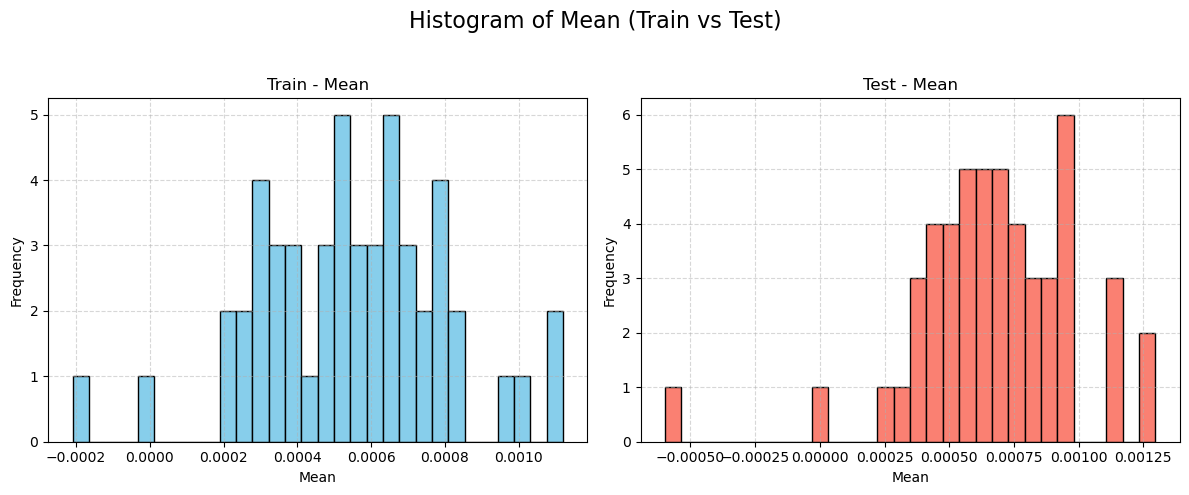

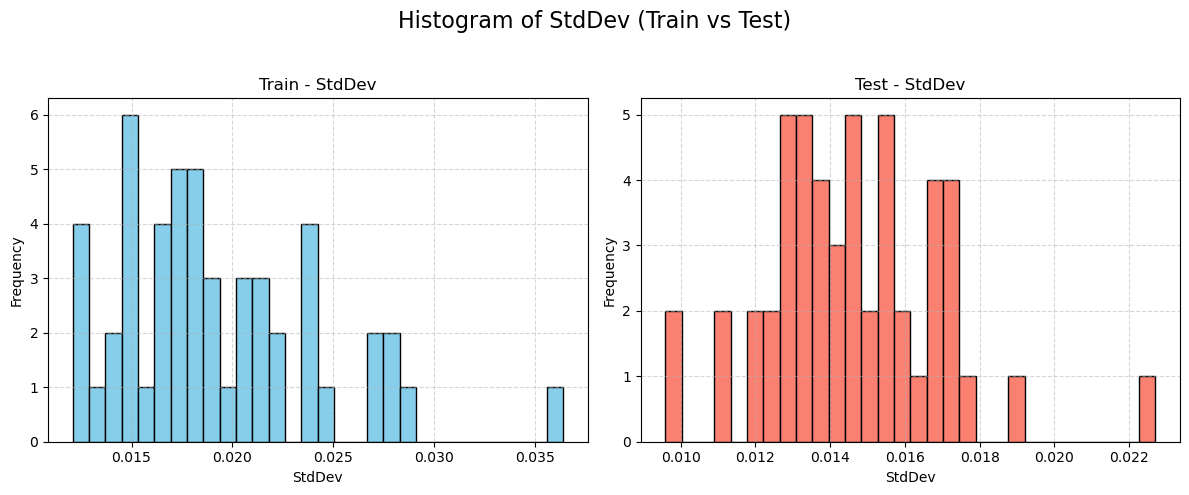

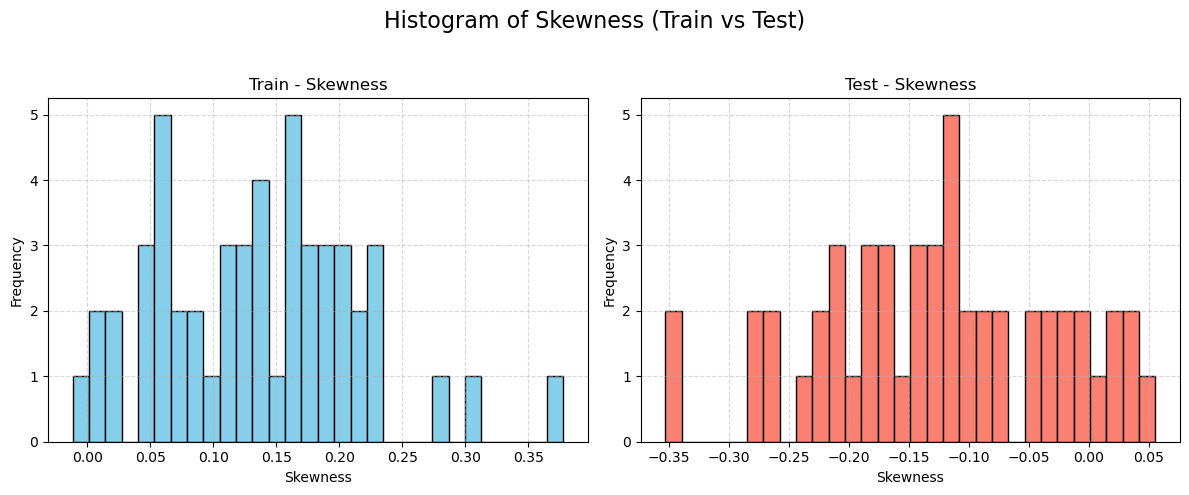

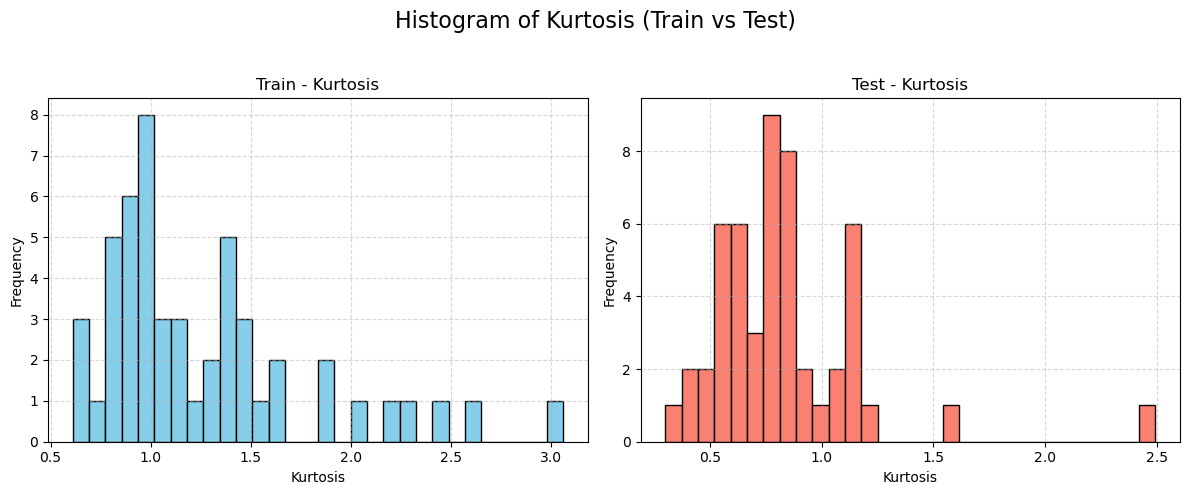

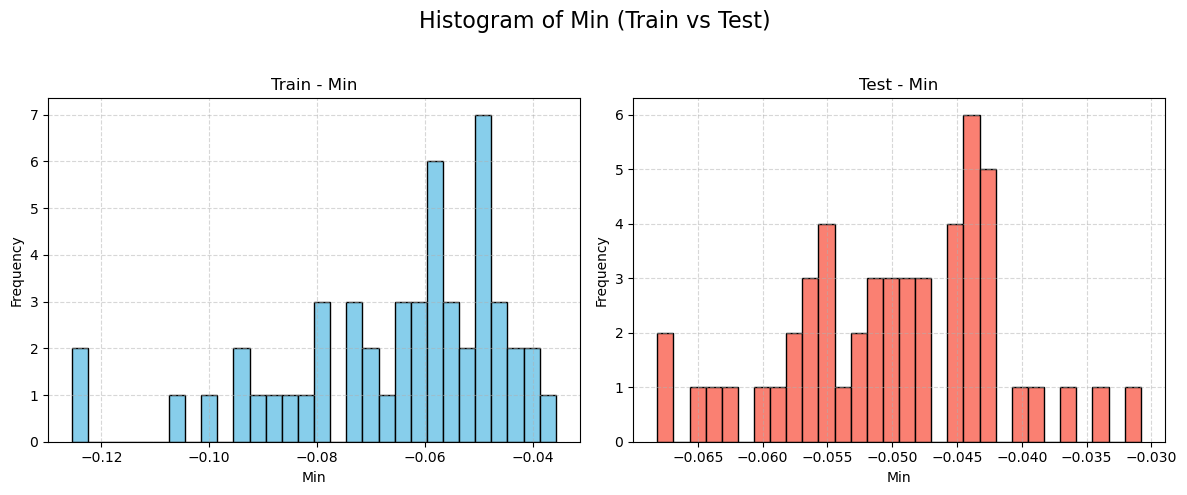

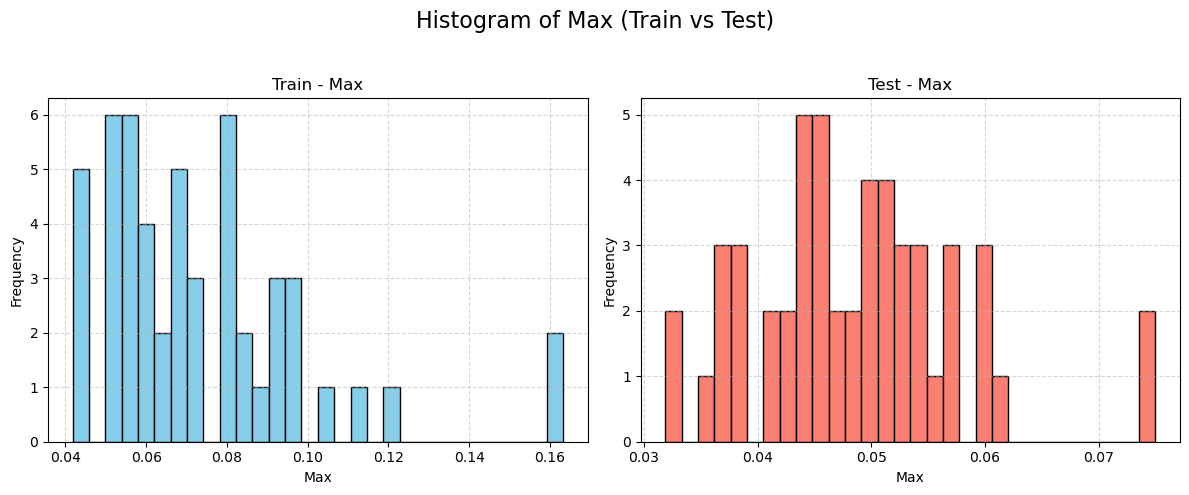

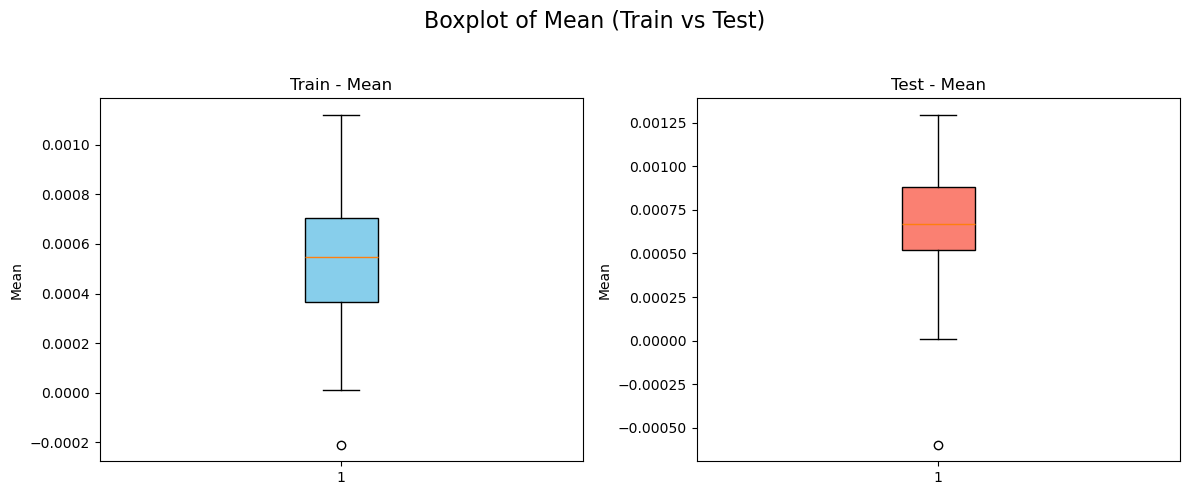

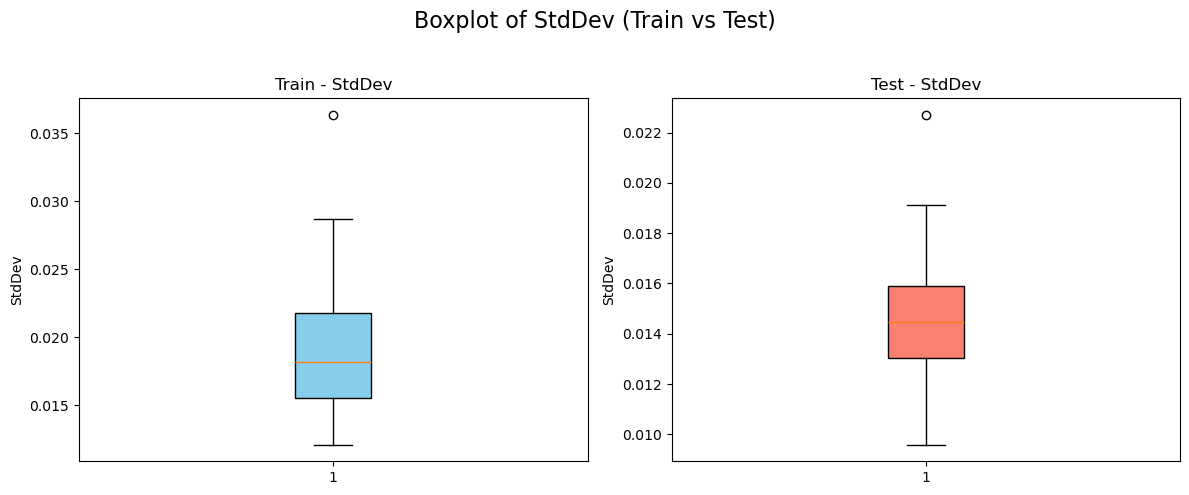

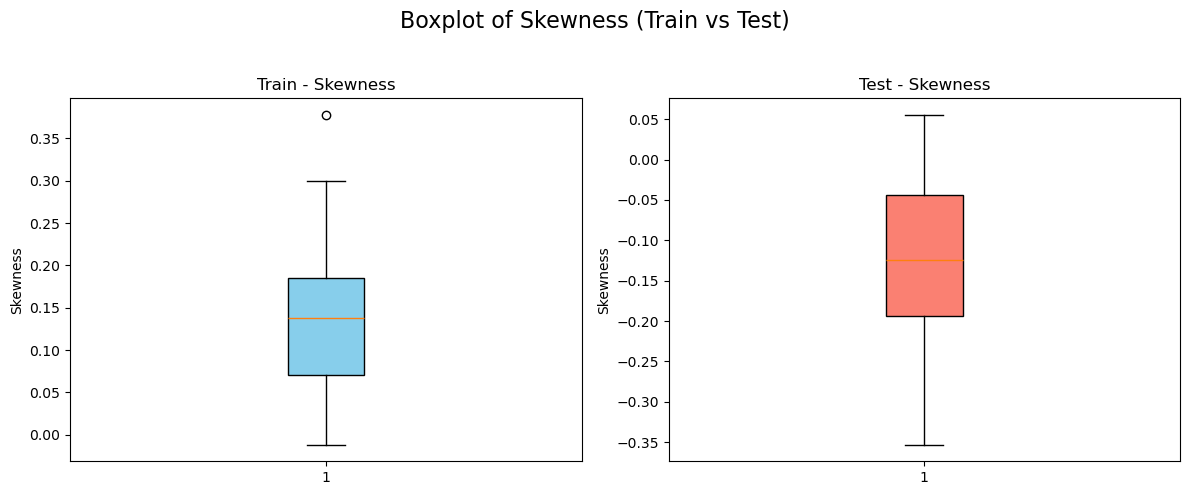

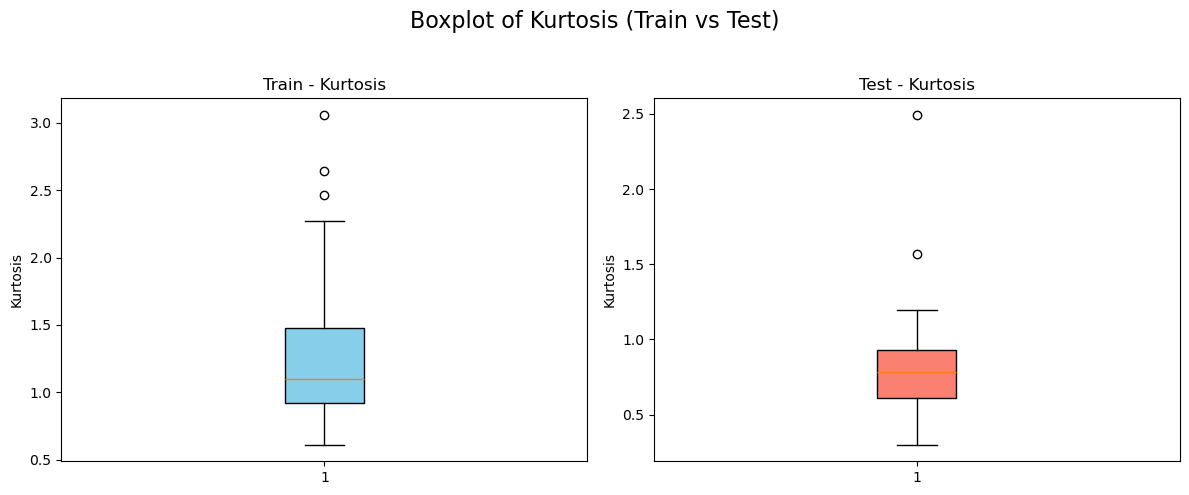

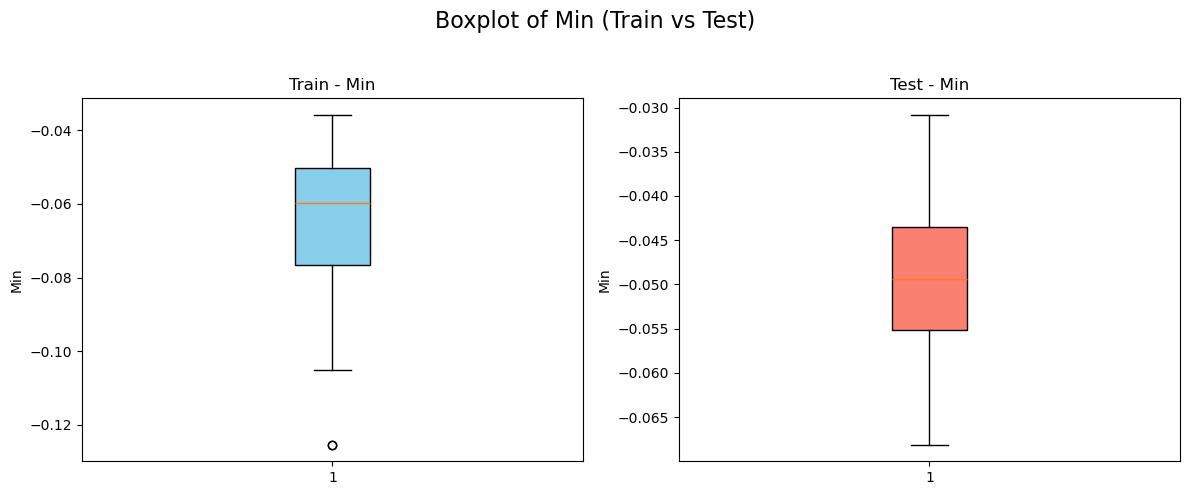

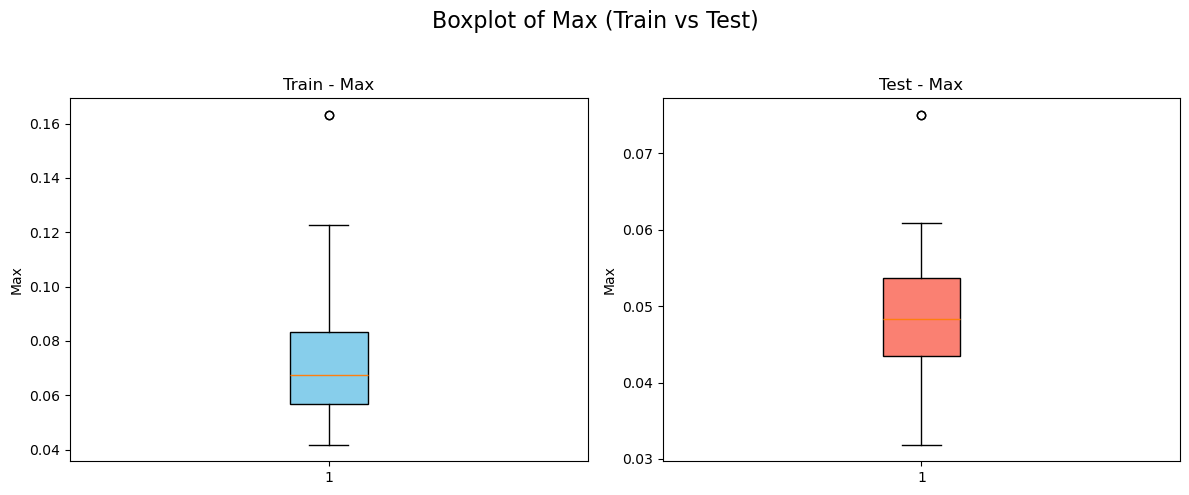

All plots generated, saved, and displayed


In [15]:
train_stats = pd.read_csv("train_descriptive_stats.csv")
test_stats = pd.read_csv("test_descriptive_stats.csv")

os.makedirs("figures", exist_ok=True)

metrics = ["Mean", "StdDev", "Skewness", "Kurtosis", "Min", "Max"]
def plot_histograms(train_df, test_df, metrics, output_dir="figures"):
    for metric in metrics:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].hist(train_df[metric], bins=30, color="skyblue", edgecolor="black")
        axs[0].set_title(f"Train - {metric}")
        axs[0].set_xlabel(metric)
        axs[0].set_ylabel("Frequency")
        axs[0].grid(True, linestyle="--", alpha=0.5)

        axs[1].hist(test_df[metric], bins=30, color="salmon", edgecolor="black")
        axs[1].set_title(f"Test - {metric}")
        axs[1].set_xlabel(metric)
        axs[1].set_ylabel("Frequency")
        axs[1].grid(True, linestyle="--", alpha=0.5)

        plt.suptitle(f"Histogram of {metric} (Train vs Test)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_dir, f"histogram_{metric}.png"), dpi=300)

        plt.show()
        plt.close()

def plot_boxplots(train_df, test_df, metrics, output_dir="figures"):
    for metric in metrics:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].boxplot(train_df[metric].dropna(), vert=True, patch_artist=True,
                       boxprops=dict(facecolor="skyblue"))
        axs[0].set_title(f"Train - {metric}")
        axs[0].set_ylabel(metric)

        axs[1].boxplot(test_df[metric].dropna(), vert=True, patch_artist=True,
                       boxprops=dict(facecolor="salmon"))
        axs[1].set_title(f"Test - {metric}")
        axs[1].set_ylabel(metric)

        plt.suptitle(f"Boxplot of {metric} (Train vs Test)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_dir, f"boxplot_{metric}.png"), dpi=300)

        plt.show()
        plt.close()

plot_histograms(train_stats, test_stats, metrics)
plot_boxplots(train_stats, test_stats, metrics)

print("All plots generated, saved, and displayed")

In [16]:
train_stats = pd.read_csv("train_descriptive_stats.csv")
test_stats  = pd.read_csv("test_descriptive_stats.csv")

columns_to_compare = ["Mean", "StdDev", "Skewness", "Kurtosis", "Min", "Max"]

train_avg = train_stats[columns_to_compare].mean()
test_avg = test_stats[columns_to_compare].mean()

change_pct = ((test_avg - train_avg) / train_avg) * 100
summary_df = pd.DataFrame({
    "Train Avg": train_avg,
    "Test Avg": test_avg,
    "Change (%)": change_pct
}).round(4)

print(summary_df)
summary_df.to_csv("summary_statistics_change.csv")

train_stats = pd.read_csv("train_descriptive_stats.csv")
test_stats  = pd.read_csv("test_descriptive_stats.csv")

columns_to_compare = ["Mean", "StdDev", "Skewness", "Kurtosis", "Min", "Max"]

train_global = train_stats.loc[train_stats['PERMNO'] == 'All', columns_to_compare].iloc[0]
test_global = test_stats.loc[test_stats['PERMNO'] == 'All', columns_to_compare].iloc[0]

change_pct = ((test_global - train_global) / train_global) * 100
summary_df = pd.DataFrame({
    "Train": train_global,
    "Test": test_global,
    "Change (%)": change_pct
}).round(4)

print(summary_df)
summary_df.to_csv("summary_statistics_change.csv")

          Train Avg  Test Avg  Change (%)
Mean         0.0005    0.0007     21.8137
StdDev       0.0193    0.0146    -24.3255
Skewness     0.1353   -0.1270   -193.8599
Kurtosis     1.2758    0.8232    -35.4773
Min         -0.0654   -0.0497    -23.9702
Max          0.0738    0.0485    -34.2669
           Train    Test  Change (%)
Mean      0.0005  0.0007     21.8198
StdDev    0.0199  0.0148    -25.7509
Skewness  0.1885 -0.1209   -164.1276
Kurtosis  3.0598  1.1971    -60.8772
Min      -0.1254 -0.0681    -45.6629
Max       0.1632  0.0750    -54.0521


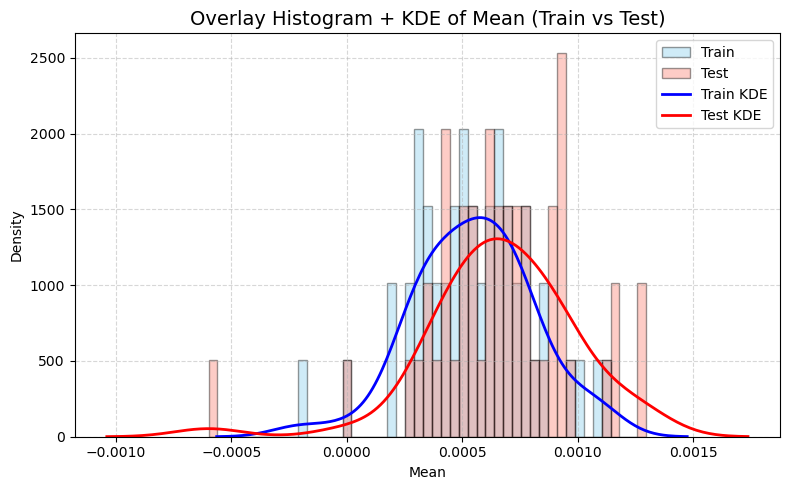

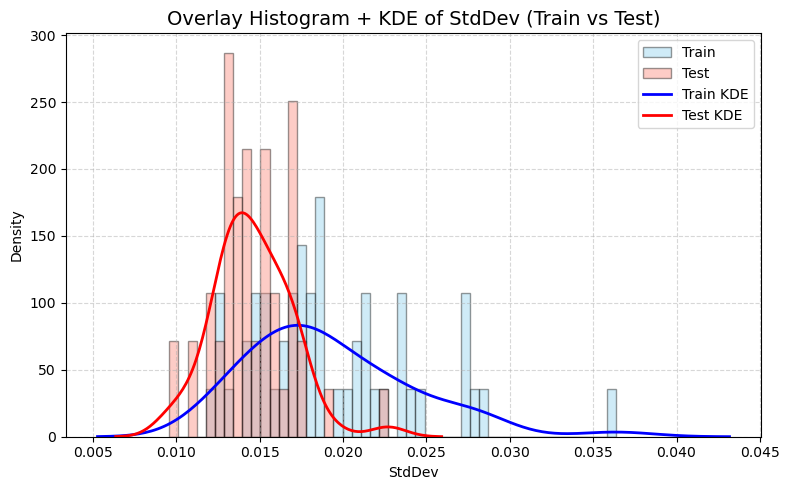

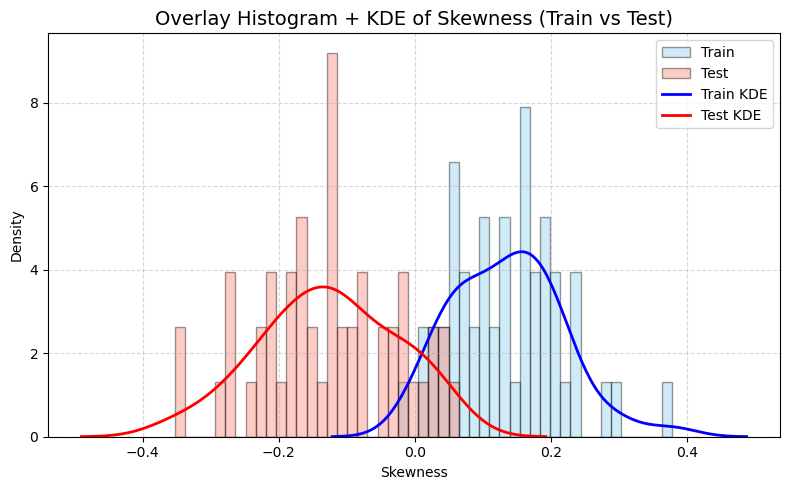

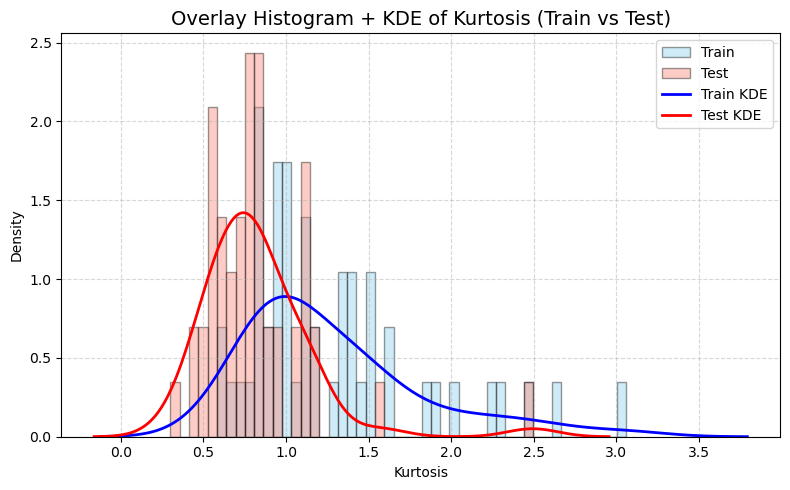

Overlay histograms + KDE generated!


In [17]:
train_stats = pd.read_csv("train_descriptive_stats.csv")
test_stats = pd.read_csv("test_descriptive_stats.csv")

os.makedirs("figures_overlay", exist_ok=True)

metrics = ["Mean", "StdDev", "Skewness",'Kurtosis']

def plot_overlay_histograms(train_df, test_df, metrics, output_dir="figures_overlay"):
    for metric in metrics:
        plt.figure(figsize=(8, 5))

        combined = pd.concat([train_df[metric], test_df[metric]])
        bins = np.linspace(combined.min(), combined.max(), 50)
        
        plt.hist(train_df[metric], bins=bins, color="skyblue", alpha=0.4, 
                 label="Train", edgecolor="black", density=True)
        plt.hist(test_df[metric], bins=bins, color="salmon", alpha=0.4, 
                 label="Test", edgecolor="black", density=True)

        sns.kdeplot(train_df[metric], color="blue", label="Train KDE", lw=2)
        sns.kdeplot(test_df[metric], color="red", label="Test KDE", lw=2)

        plt.title(f"Overlay Histogram + KDE of {metric} (Train vs Test)", fontsize=14)
        plt.xlabel(metric)
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()

        plt.savefig(os.path.join(output_dir, f"overlay_histogram_kde_{metric}.png"), dpi=300)
        plt.show()
        plt.close()

plot_overlay_histograms(train_stats, test_stats, metrics)
print("Overlay histograms + KDE generated!")

=== Return Distribution Balance Check Analysis ===
Based on all_window_datasets_unscaled.npz file

Data file loaded successfully!
The file contains 32 datasets

=== Window Size: 5 days ===
Training set: Up = 99,454, Down = 97,466
  Up ratio: 50.5%
  Up mean return: 0.014362
  Down mean return: -0.013605
Test set: Up = 57,922, Down = 52,928
  Up ratio: 52.3%
  Up mean return: 0.011841
  Down mean return: -0.011839

=== Window Size: 21 days ===
Training set: Up = 99,107, Down = 97,013
  Up ratio: 50.5%
  Up mean return: 0.014315
  Down mean return: -0.013559
Test set: Up = 57,922, Down = 52,928
  Up ratio: 52.3%
  Up mean return: 0.011841
  Down mean return: -0.011839

=== Window Size: 252 days ===
Training set: Up = 93,661, Down = 90,909
  Up ratio: 50.7%
  Up mean return: 0.013699
  Down mean return: -0.012963
Test set: Up = 57,922, Down = 52,928
  Up ratio: 52.3%
  Up mean return: 0.011841
  Down mean return: -0.011839

=== Window Size: 512 days ===
Training set: Up = 87,238, Down = 8

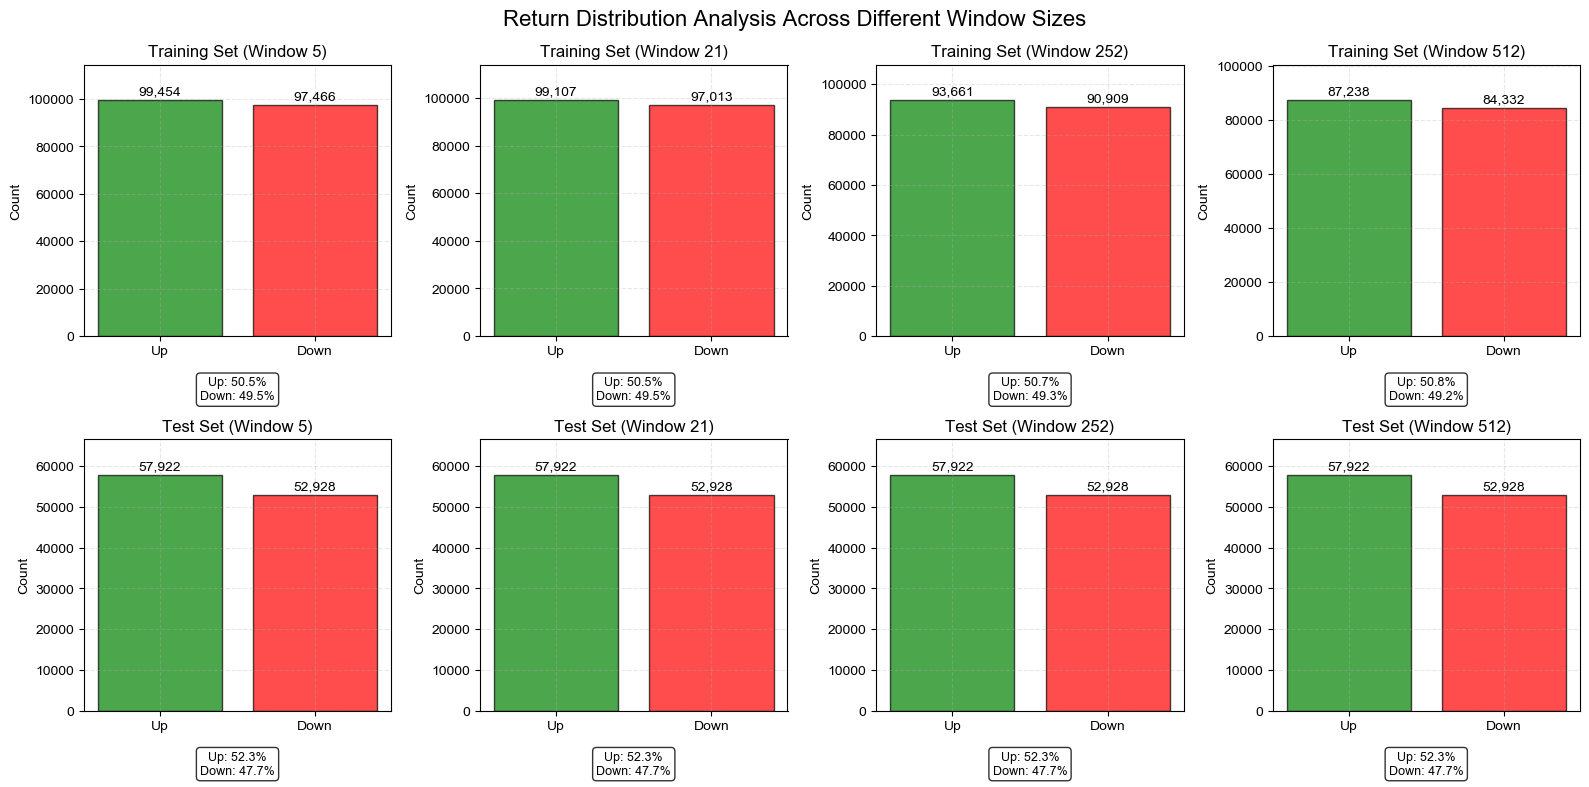


Performing statistical tests...
=== Statistical Tests for Return Distribution Balance ===

Window Size: 5 days
--------------------------------------------------
Training set balance:
  Up: 99,454 (50.5%)
  Down: 97,466 (49.5%)
  Chi-square statistic: 20.0698
  Mean return - Up: 0.014362, Down: -0.013605
Test set balance:
  Up: 57,922 (52.3%)
  Down: 52,928 (47.7%)
  Chi-square statistic: 224.9890
  Mean return - Up: 0.011841, Down: -0.011839
Train vs Test set distribution consistency:
  Chi-square statistic: 86.6415
  p-value: 0.000000
  Significantly different distributions (α=0.05)
KS test for up returns: statistic=0.0685, p-value=0.000000
KS test for down returns: statistic=0.0557, p-value=0.000000


Window Size: 21 days
--------------------------------------------------
Training set balance:
  Up: 99,107 (50.5%)
  Down: 97,013 (49.5%)
  Chi-square statistic: 22.3579
  Mean return - Up: 0.014315, Down: -0.013559
Test set balance:
  Up: 57,922 (52.3%)
  Down: 52,928 (47.7%)
  Chi-s

In [22]:

"""
Return Distribution Balance Check Analysis
Based on all_window_datasets_unscaled.npz file
"""
from scipy.stats import chi2_contingency, ks_2samp

plt.rcParams['axes.unicode_minus'] = False

def load_data():
    """Load npz data file"""
    data_path = "/Users/june/Documents/University of Manchester/Data Science/ERP/Project code/1_Data_Preprocessing/all_window_datasets_unscaled.npz"
    data = np.load(data_path, allow_pickle=True)
    print("Data file loaded successfully!")
    print(f"The file contains {len(data.keys())} datasets")
    return data

def create_balance_check_from_npz(data, windows=[5, 21, 252, 512]):
    """
    Create return distribution balance check analysis based on npz file.
    Analyze the distribution of up (positive) and down (non-positive) returns for different window sizes.
    """
    
    # Create output directory
    os.makedirs("balance_check_results", exist_ok=True)
    
    results = {}
    
    for window in windows:
        print(f"\n=== Window Size: {window} days ===")
        
        # Read train and test return data
        y_train_key = f'y_train_{window}'
        y_test_key = f'y_test_{window}'
        
        if y_train_key in data and y_test_key in data:
            y_train = data[y_train_key]
            y_test = data[y_test_key]
            
            # Analyze training set
            train_up = y_train[y_train > 0]
            train_down = y_train[y_train <= 0]
            
            # Analyze test set
            test_up = y_test[y_test > 0]
            test_down = y_test[y_test <= 0]
            
            # Save results
            results[f"Training Set (Window {window})"] = {
                'up_count': len(train_up),
                'down_count': len(train_down),
                'up_returns': train_up,
                'down_returns': train_down,
                'up_mean': np.mean(train_up) if len(train_up) > 0 else 0,
                'down_mean': np.mean(train_down) if len(train_down) > 0 else 0,
                'total': len(y_train)
            }
            
            results[f"Test Set (Window {window})"] = {
                'up_count': len(test_up),
                'down_count': len(test_down),
                'up_returns': test_up,
                'down_returns': test_down,
                'up_mean': np.mean(test_up) if len(test_up) > 0 else 0,
                'down_mean': np.mean(test_down) if len(test_down) > 0 else 0,
                'total': len(y_test)
            }
            
            # Print basic statistics
            print(f"Training set: Up = {len(train_up):,}, Down = {len(train_down):,}")
            print(f"  Up ratio: {len(train_up)/len(y_train)*100:.1f}%")
            print(f"  Up mean return: {np.mean(train_up):.6f}" if len(train_up) > 0 else "  Up mean return: N/A")
            print(f"  Down mean return: {np.mean(train_down):.6f}" if len(train_down) > 0 else "  Down mean return: N/A")
            
            print(f"Test set: Up = {len(test_up):,}, Down = {len(test_down):,}")
            print(f"  Up ratio: {len(test_up)/len(y_test)*100:.1f}%")
            print(f"  Up mean return: {np.mean(test_up):.6f}" if len(test_up) > 0 else "  Up mean return: N/A")
            print(f"  Down mean return: {np.mean(test_down):.6f}" if len(test_down) > 0 else "  Down mean return: N/A")
        else:
            print(f"Warning: Data for window {window} not found")
    
    return results

def plot_return_distribution_balance_npz(balance_results, windows=[5, 21, 252, 512]):
    """
    Create visualization for return distribution balance check based on npz data.
    Show up/down return counts for train and test sets across different window sizes.
    """

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Return Distribution Analysis Across Different Window Sizes', fontsize=16, fontweight='bold')
    
    datasets = ['Training Set', 'Test Set']
    colors = ['green', 'red']  # Green for up, red for down
    
    for row, dataset in enumerate(datasets):
        for col, window in enumerate(windows):
            ax = axes[row, col]
            
            # Get results for current dataset and window
            key = f"{dataset} (Window {window})"
            if key in balance_results:
                data_info = balance_results[key]
                
                # Prepare data for bar plot
                categories = ['Up', 'Down']
                counts = [data_info['up_count'], data_info['down_count']]
                
                # Draw bar plot
                bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
                
                # Add value labels on bars
                for i, (bar, count) in enumerate(zip(bars, counts)):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                           f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
                
                # Set title and labels
                ax.set_title(f'{dataset} (Window {window})', fontsize=12, fontweight='bold')
                ax.set_ylabel('Count', fontsize=10)
                ax.grid(True, linestyle='--', alpha=0.3)
                
                # Set y-axis limit for better display
                max_count = max(counts)
                ax.set_ylim(0, max_count * 1.15)
                
                # Add ratio info at the bottom of subplot
                total = sum(counts)
                up_pct = (counts[0] / total) * 100 if total > 0 else 0
                down_pct = (counts[1] / total) * 100 if total > 0 else 0
                
                ax.text(0.5, -0.15, f'Up: {up_pct:.1f}%\nDown: {down_pct:.1f}%', 
                       transform=ax.transAxes, ha='center', va='top', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig("balance_check_results/return_distribution_balance_check.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def statistical_balance_tests_npz(balance_results, windows=[5, 21, 252, 512]):
    """
    Perform statistical tests for return distribution balance based on npz data.
    """
    
    print("=== Statistical Tests for Return Distribution Balance ===\n")
    
    # Create summary table
    test_results = []
    
    for window in windows:
        print(f"Window Size: {window} days")
        print("-" * 50)
        
        # Get train and test set data
        train_key = f"Training Set (Window {window})"
        test_key = f"Test Set (Window {window})"
        
        if train_key in balance_results and test_key in balance_results:
            train_data = balance_results[train_key]
            test_data = balance_results[test_key]
            
            # 1. Get count data
            train_up, train_down = train_data['up_count'], train_data['down_count']
            test_up, test_down = test_data['up_count'], test_data['down_count']
            
            # Internal balance test for training set (expected 50:50)
            total_train = train_up + train_down
            expected_train = total_train / 2
            chi2_train = ((train_up - expected_train)**2 + (train_down - expected_train)**2) / expected_train
            
            # Internal balance test for test set
            total_test = test_up + test_down
            expected_test = total_test / 2
            chi2_test = ((test_up - expected_test)**2 + (test_down - expected_test)**2) / expected_test
            
            print(f"Training set balance:")
            print(f"  Up: {train_up:,} ({train_up/total_train*100:.1f}%)")
            print(f"  Down: {train_down:,} ({train_down/total_train*100:.1f}%)")
            print(f"  Chi-square statistic: {chi2_train:.4f}")
            print(f"  Mean return - Up: {train_data['up_mean']:.6f}, Down: {train_data['down_mean']:.6f}")
            
            print(f"Test set balance:")
            print(f"  Up: {test_up:,} ({test_up/total_test*100:.1f}%)")
            print(f"  Down: {test_down:,} ({test_down/total_test*100:.1f}%)")
            print(f"  Chi-square statistic: {chi2_test:.4f}")
            print(f"  Mean return - Up: {test_data['up_mean']:.6f}, Down: {test_data['down_mean']:.6f}")
            
            # 2. Consistency test between train and test set
            contingency_table = np.array([[train_up, train_down], [test_up, test_down]])
            chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
            
            print(f"Train vs Test set distribution consistency:")
            print(f"  Chi-square statistic: {chi2_stat:.4f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  {'Significantly different distributions' if p_value < 0.05 else 'No significant difference in distributions'} (α=0.05)")
            
            # 3. Kolmogorov-Smirnov test
            if len(train_data['up_returns']) > 0 and len(test_data['up_returns']) > 0:
                ks_stat_up, ks_p_up = ks_2samp(train_data['up_returns'], test_data['up_returns'])
                print(f"KS test for up returns: statistic={ks_stat_up:.4f}, p-value={ks_p_up:.6f}")
            
            if len(train_data['down_returns']) > 0 and len(test_data['down_returns']) > 0:
                ks_stat_down, ks_p_down = ks_2samp(train_data['down_returns'], test_data['down_returns'])
                print(f"KS test for down returns: statistic={ks_stat_down:.4f}, p-value={ks_p_down:.6f}")
            
            # Save results to summary table
            result_row = {
                'Window': window,
                'Train_Up_Pct': train_up/total_train*100,
                'Train_Down_Pct': train_down/total_train*100,
                'Test_Up_Pct': test_up/total_test*100,
                'Test_Down_Pct': test_down/total_test*100,
                'Train_Up_Mean': train_data['up_mean'],
                'Train_Down_Mean': train_data['down_mean'],
                'Test_Up_Mean': test_data['up_mean'],
                'Test_Down_Mean': test_data['down_mean'],
                'Chi2_Consistency': chi2_stat,
                'P_Value_Consistency': p_value,
                'Significant_Diff': p_value < 0.05
            }
            test_results.append(result_row)
            
        print("\n")
    
    # Create summary DataFrame
    results_df = pd.DataFrame(test_results)
    print("=== Statistical Test Results Summary ===")
    print(results_df.round(4))
    
    # Save results
    results_df.to_csv("balance_check_results/balance_test_results.csv", index=False)
    
    return results_df

def main():
    """Main function"""
    print("=== Return Distribution Balance Check Analysis ===")
    print("Based on all_window_datasets_unscaled.npz file\n")
    
    # 1. Load data
    data = load_data()
    
    # 2. Perform balance check analysis
    windows = [5, 21, 252, 512]
    balance_results = create_balance_check_from_npz(data, windows)
    
    # 3. Create visualization
    print("\nCreating return distribution balance visualization...")
    plot_return_distribution_balance_npz(balance_results)
    
    # 4. Perform statistical tests
    print("\nPerforming statistical tests...")
    test_summary = statistical_balance_tests_npz(balance_results)
    
    print("\n=== Analysis Completed ===")
    print("All results have been saved to the balance_check_results/ directory")
    print("- return_distribution_balance_check.png: Main visualization result")
    print("- balance_test_results.csv: Statistical test results summary")

if __name__ == "__main__":
    main()


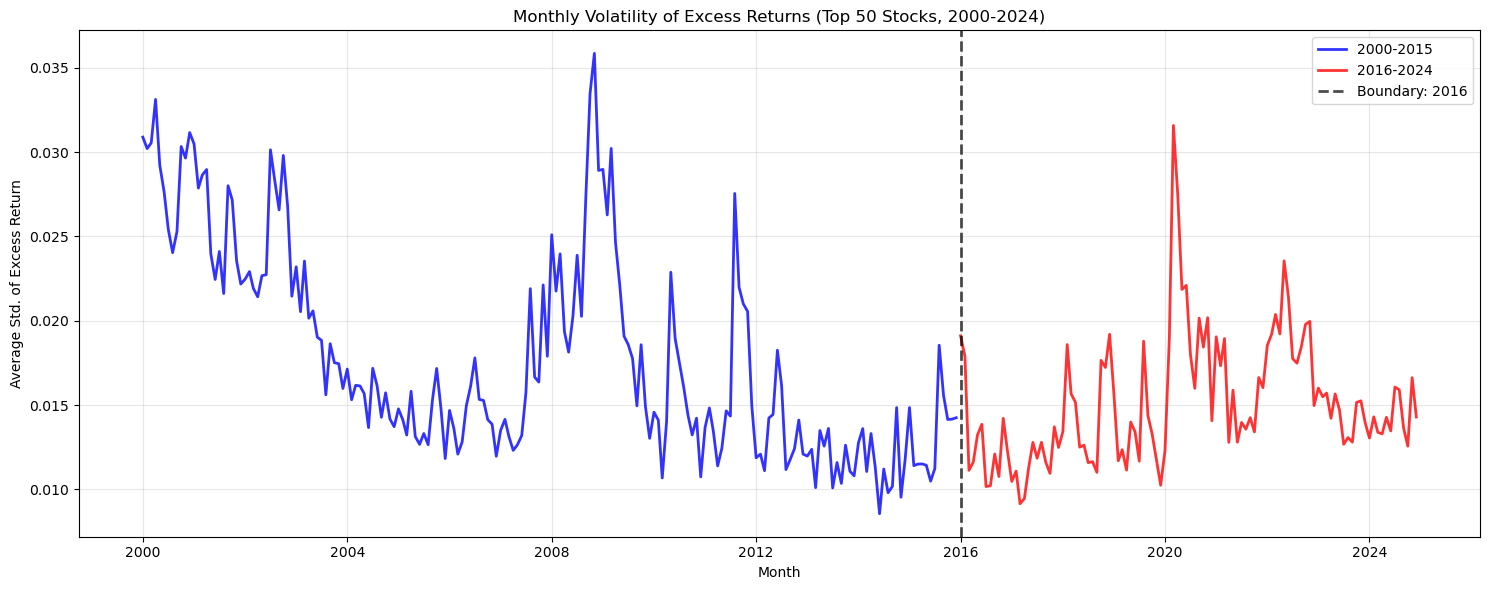

Two-stage volatility time series plot with boundary line generated!


In [20]:
csv_path_recent = "/Users/june/Documents/University of Manchester/Data Science/ERP/Project code/1_Data_Preprocessing/CRSP_2016_2024_top50_with_exret_cleaned.csv"
df_recent = pd.read_csv(csv_path_recent)

df_recent["date"] = pd.to_datetime(df_recent["date"])
df_recent["year_month"] = df_recent["date"].dt.to_period("M").astype(str)

monthly_volatility_recent = df_recent.groupby(["year_month", "PERMNO"])["EXRET"].std().reset_index(name="std_exret")
mean_monthly_volatility_recent = monthly_volatility_recent.groupby("year_month")["std_exret"].mean().reset_index()
mean_monthly_volatility_recent["year_month"] = pd.to_datetime(mean_monthly_volatility_recent["year_month"])

csv_path_early = "/Users/june/Documents/University of Manchester/Data Science/ERP/Project code/1_Data_Preprocessing/CRSP_2000_2015_top50_with_exret_cleaned.csv"
df_early = pd.read_csv(csv_path_early)

df_early["date"] = pd.to_datetime(df_early["date"])
df_early["year_month"] = df_early["date"].dt.to_period("M").astype(str)

monthly_volatility_early = df_early.groupby(["year_month", "PERMNO"])["EXRET"].std().reset_index(name="std_exret")
mean_monthly_volatility_early = monthly_volatility_early.groupby("year_month")["std_exret"].mean().reset_index()
mean_monthly_volatility_early["year_month"] = pd.to_datetime(mean_monthly_volatility_early["year_month"])

# Plot two-stage time series
plt.figure(figsize=(15, 6))

# Plot 2000-2015 data (blue)
plt.plot(mean_monthly_volatility_early["year_month"], mean_monthly_volatility_early["std_exret"], 
         linewidth=2, color='blue', label='2000-2015', alpha=0.8)

# Plot 2016-2024 data (red)
plt.plot(mean_monthly_volatility_recent["year_month"], mean_monthly_volatility_recent["std_exret"], 
         linewidth=2, color='red', label='2016-2024', alpha=0.8)

# Add boundary line (January 1, 2016)
boundary_date = pd.to_datetime('2016-01-01')
plt.axvline(x=boundary_date, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Boundary: 2016')

plt.title("Monthly Volatility of Excess Returns (Top 50 Stocks, 2000-2024)")
plt.xlabel("Month")
plt.ylabel("Average Std. of Excess Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Two-stage volatility time series plot with boundary line generated!")

In [26]:
import pandas as pd

# File paths
standardized_path = "/Users/june/Documents/University of Manchester/Data Science/ERP/Project code/标准化比较/标准化结果.xlsx"
non_standardized_path = "/Users/june/Documents/University of Manchester/Data Science/ERP/Project code/标准化比较/无标准化.xlsx"

IMBALANCE_THRESHOLD = 0.15

def evaluate_performance(df: pd.DataFrame, label: str):
    print(f"==== {label} ====")
    
    # 1. Number of positive R²
    positive_r2_count = (df["R2_zero"] > 0).sum()
    total = len(df)
    print(f"Positive R² count: {positive_r2_count}/{total} ({positive_r2_count/total:.2%})")

    # 2. Mean Directional Accuracy
    mean_da = df["Directional Accuracy"].mean()
    print(f"Mean Directional Accuracy (DA): {mean_da:.4f}")

    # 3. Balanced Accuracy + directional imbalance detection
    mean_up = df["Up_Directional_Acc"].mean()
    mean_down = df["Down_Directional_Acc"].mean()
    balanced_acc = (mean_up + mean_down) / 2
    imbalance = abs(mean_up - mean_down)

    print(f"Balanced Accuracy (BA): {balanced_acc:.4f} (Up: {mean_up:.4f}, Down: {mean_down:.4f})")
    print(f"Direction Imbalance: {imbalance:.4f}")

    if imbalance > IMBALANCE_THRESHOLD:
        print(f"  Directional Accuracy is unbalanced! (> {IMBALANCE_THRESHOLD})")
    else:
        print(f" Directional Accuracy is balanced. (<= {IMBALANCE_THRESHOLD})")

    print()

# Read data
df_std = pd.read_excel(standardized_path)
df_nonstd = pd.read_excel(non_standardized_path)

# Execute comparison
evaluate_performance(df_std, "Standardized")
evaluate_performance(df_nonstd, "Non-Standardized")


==== Standardized ====
Positive R² count: 6/32 (18.75%)
Mean Directional Accuracy (DA): 0.5113
Balanced Accuracy (BA): 0.5043 (Up: 0.6497, Down: 0.3590)
Direction Imbalance: 0.2906
  Directional Accuracy is unbalanced! (> 0.15)

==== Non-Standardized ====
Positive R² count: 2/32 (6.25%)
Mean Directional Accuracy (DA): 0.5115
Balanced Accuracy (BA): 0.5030 (Up: 0.6806, Down: 0.3253)
Direction Imbalance: 0.3554
  Directional Accuracy is unbalanced! (> 0.15)

